In [359]:
import pandas as pd
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('df5_2102.csv')

sensor_id = [329, 332, 335]
freezer_id = [344, 362, 368]

In [393]:
df_prime = df.copy()

In [394]:
df_prime = df_prime.dropna()

In [395]:
df_prime

,gw_time,gw_time.1,status_329,avg_temperature_329,avg_humidity_329,temperature_329,humidity_329,battery_329,available_329,status_332,...,run_time_368,dT_329,dT_332,dT_335,temperature_329_prime,dT_329_prime,temperature_332_prime,dT_332_prime,temperature_335_prime,dT_335_prime
9,2021-02-01 00:04:36,2021-02-01 00:04:36,1,-20.27,60.09,-20.28,63.21,100,1,1,...,0.0,0.01,0.02,0.01,-20.29,0.01,-20.25,0.00,-20.29,0.00
10,2021-02-01 00:05:06,2021-02-01 00:05:06,1,-20.27,60.02,-20.29,63.15,100,1,1,...,0.0,-0.01,-0.01,-0.01,-20.28,0.01,-20.23,0.02,-20.28,0.01
11,2021-02-01 00:05:36,2021-02-01 00:05:36,1,-20.27,59.96,-20.29,63.07,100,1,1,...,0.0,0.00,0.01,0.01,-20.29,-0.01,-20.24,-0.01,-20.29,-0.01
12,2021-02-01 00:06:06,2021-02-01 00:06:06,1,-20.26,59.90,-20.29,63.04,100,1,1,...,1.0,0.00,0.01,0.01,-20.29,0.00,-20.23,0.01,-20.28,0.01
13,2021-02-01 00:06:36,2021-02-01 00:06:36,1,-20.26,59.89,-20.30,62.98,100,1,1,...,1.0,-0.01,0.01,-0.01,-20.29,0.00,-20.22,0.01,-20.27,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80124,2021-02-28 23:57:33,2021-02-28 23:57:33,1,-19.81,46.37,-18.94,45.02,100,1,1,...,1432.0,0.00,0.01,0.01,-18.94,0.01,-19.82,0.00,-20.68,0.00
80125,2021-02-28 23:58:03,2021-02-28 23:58:03,1,-19.81,46.37,-18.95,44.98,100,1,1,...,1433.0,-0.01,0.01,0.00,-18.94,0.00,-19.81,0.01,-20.67,0.01
80126,2021-02-28 23:58:33,2021-02-28 23:58:33,1,-19.79,46.37,-18.93,45.00,100,1,1,...,1433.0,0.02,0.00,0.02,-18.95,-0.01,-19.80,0.01,-20.67,0.00
80127,2021-02-28 23:59:03,2021-02-28 23:59:03,1,-19.79,46.35,-18.95,44.98,100,1,1,...,1434.0,-0.02,0.01,0.01,-18.93,0.02,-19.80,0.00,-20.65,0.02


In [396]:
col1 = ['dT_329'] + ['operation_'+str(_id) for _id in freezer_id]
col2 = ['dT_329'] + ['freez_run_'+str(_id) for _id in freezer_id]
co13 = ['dT_329'] + ['freez_run_'+str(_id) for _id in freezer_id] + ['operation_'+str(_id) for _id in freezer_id]
target = 'dT_329'

In [398]:
df_prime = df_prime[co13] #+ ['temperature_329_prime']]

In [399]:
train_size = int(len(df_prime) * 0.9)
test_size = len(df_prime) - train_size
train, test = df_prime.iloc[0:train_size], df_prime.iloc[train_size:len(df)]
print(len(train), len(test))

72108 8012


In [401]:
from sklearn.preprocessing import MinMaxScaler

f_columns =  ['freez_run_'+str(_id) for _id in freezer_id]#['temperature_329_prime'] +

f_transformer = MinMaxScaler()
l_transformer = MinMaxScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
l_transformer = l_transformer.fit(train[[target]])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train[target] = l_transformer.transform(train[[target]])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test[target] = l_transformer.transform(test[[target]])
train= train.reset_index(drop = True)
test= test.reset_index(drop = True)

In [402]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [403]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train.drop(columns = [target]), train[target], time_steps)
X_test, y_test = create_dataset(test.drop(columns = [target]), test[target], time_steps)

print(X_train.shape, y_train.shape)

(72098, 10, 6) (72098,)


In [453]:
X_train.shape[0]/64

1126.53125

In [477]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(TimeDistributed(Dense(64, activation=LeakyReLU())))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(64, activation=LeakyReLU())))
# model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(TimeDistributed(Dense(8)))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
filename = './tmp_checkpoint.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_84 (Bidirecti  (None, 10, 128)          36352     
 onal)                                                           
                                                                 
 batch_normalization_82 (Bat  (None, 10, 128)          512       
 chNormalization)                                                
                                                                 
 bidirectional_85 (Bidirecti  (None, 10, 128)          98816     
 onal)                                                           
                                                                 
 batch_normalization_83 (Bat  (None, 10, 128)          512       
 chNormalization)                                                
                                                                 
 bidirectional_86 (Bidirecti  (None, 10, 128)        

In [435]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# model = keras.Sequential()
# model.add(
#   keras.layers.Bidirectional(
#     keras.layers.LSTM(
#       units=128,
#       return_sequences=True, stateful=True ,
#       input_shape=(X_train.shape[1], X_train.shape[2])
#     )
#   )
# )
# model.add(BatchNormalization())
# model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=True)))
# model.add(BatchNormalization())
# model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=True)))
# model.add(BatchNormalization())
# model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=True)))
# model.add(TimeDistributed(Dense(64, activation=LeakyReLU())))
# # model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(TimeDistributed(Dense(64, activation=LeakyReLU())))
# # model.add(Dropout(0.2))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Dense(1)))

# model.compile(loss='mean_squared_error', optimizer='adam')
# filename = './tmp_checkpoint.h5'
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
# early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [478]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=256, 
    validation_split=0.1,
    shuffle=False,
    callbacks= [early_stop, checkpoint]
)

Epoch 1/30
254/254 [==============================] - ETA: 0s - loss: 0.3302
Epoch 1: val_loss improved from inf to 0.02635, saving model to .\tmp_checkpoint.h5
254/254 [==============================] - 24s 49ms/step - loss: 0.3302 - val_loss: 0.0264
Epoch 2/30
253/254 [============================>.] - ETA: 0s - loss: 0.0413
Epoch 2: val_loss did not improve from 0.02635
254/254 [==============================] - 9s 36ms/step - loss: 0.0412 - val_loss: 0.0286
Epoch 3/30
253/254 [============================>.] - ETA: 0s - loss: 0.0187
Epoch 3: val_loss improved from 0.02635 to 0.02278, saving model to .\tmp_checkpoint.h5
254/254 [==============================] - 9s 37ms/step - loss: 0.0186 - val_loss: 0.0228
Epoch 4/30
253/254 [============================>.] - ETA: 0s - loss: 0.0117
Epoch 4: val_loss improved from 0.02278 to 0.01774, saving model to .\tmp_checkpoint.h5
254/254 [==============================] - 9s 37ms/step - loss: 0.0117 - val_loss: 0.0177
Epoch 5/30
253/254 [====

In [488]:
len(y_pred[0])

10

In [479]:
model.load_weights(filename)

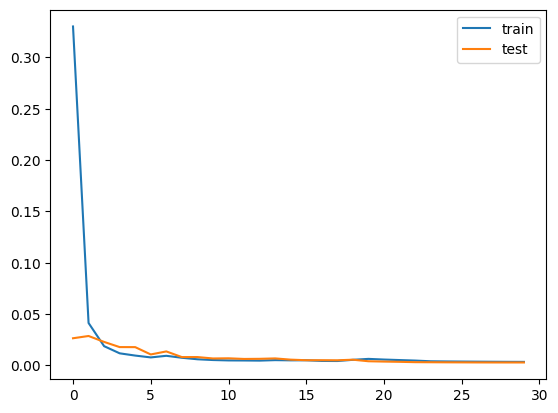

In [480]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [481]:
y_pred = model.predict(X_test)

251/251 [==============================] - 6s 11ms/step


In [486]:
y_pred

array([[[0.43899882],
        [0.43959627],
        [0.44718745],
        ...,
        [0.43948764],
        [0.43398494],
        [0.4332204 ]],

       [[0.44078982],
        [0.44185504],
        [0.44586715],
        ...,
        [0.42912427],
        [0.4337117 ],
        [0.4306252 ]],

       [[0.4427196 ],
        [0.4455318 ],
        [0.44782397],
        ...,
        [0.42800894],
        [0.43501958],
        [0.4300936 ]],

       ...,

       [[0.43662736],
        [0.44503447],
        [0.44042453],
        ...,
        [0.4455934 ],
        [0.43983147],
        [0.42637494]],

       [[0.43831095],
        [0.44611403],
        [0.4433755 ],
        ...,
        [0.45157382],
        [0.4421213 ],
        [0.4314409 ]],

       [[0.43946177],
        [0.44622913],
        [0.44628796],
        ...,
        [0.43736884],
        [0.44445246],
        [0.4408134 ]]], dtype=float32)

In [484]:
y_train_inv = l_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = l_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = l_transformer.inverse_transform(y_pred)

ValueError: Found array with dim 3. None expected <= 2.

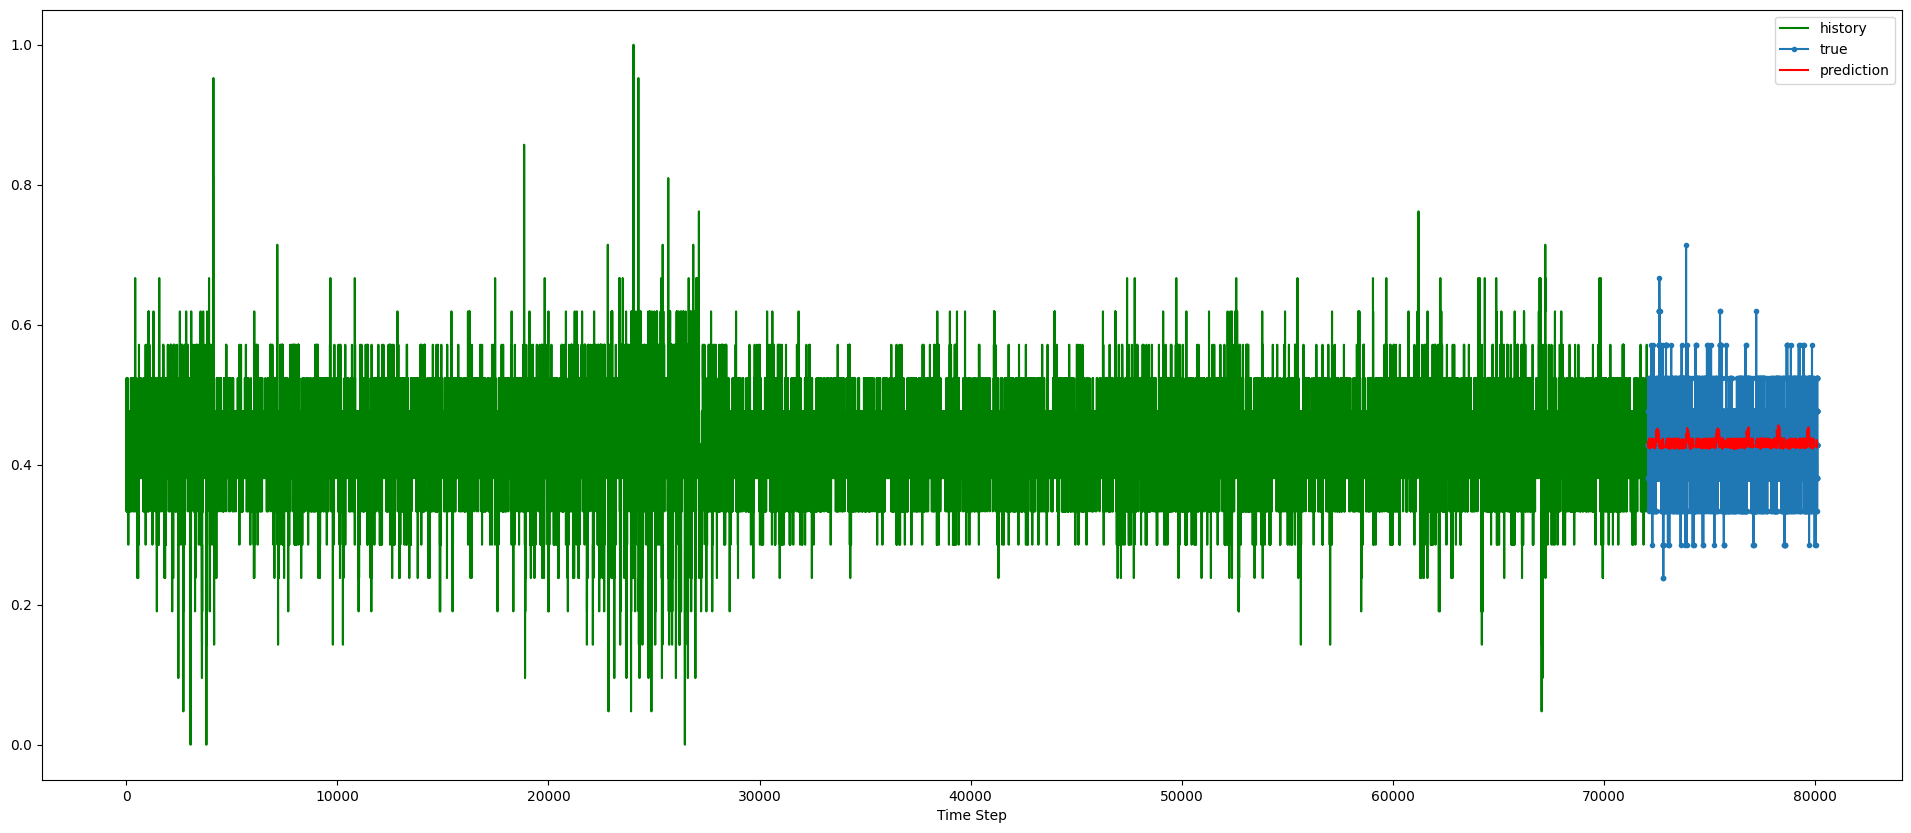

In [485]:
plt.figure(figsize=(24,10))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.xlabel('Time Step')
plt.legend()
plt.show();

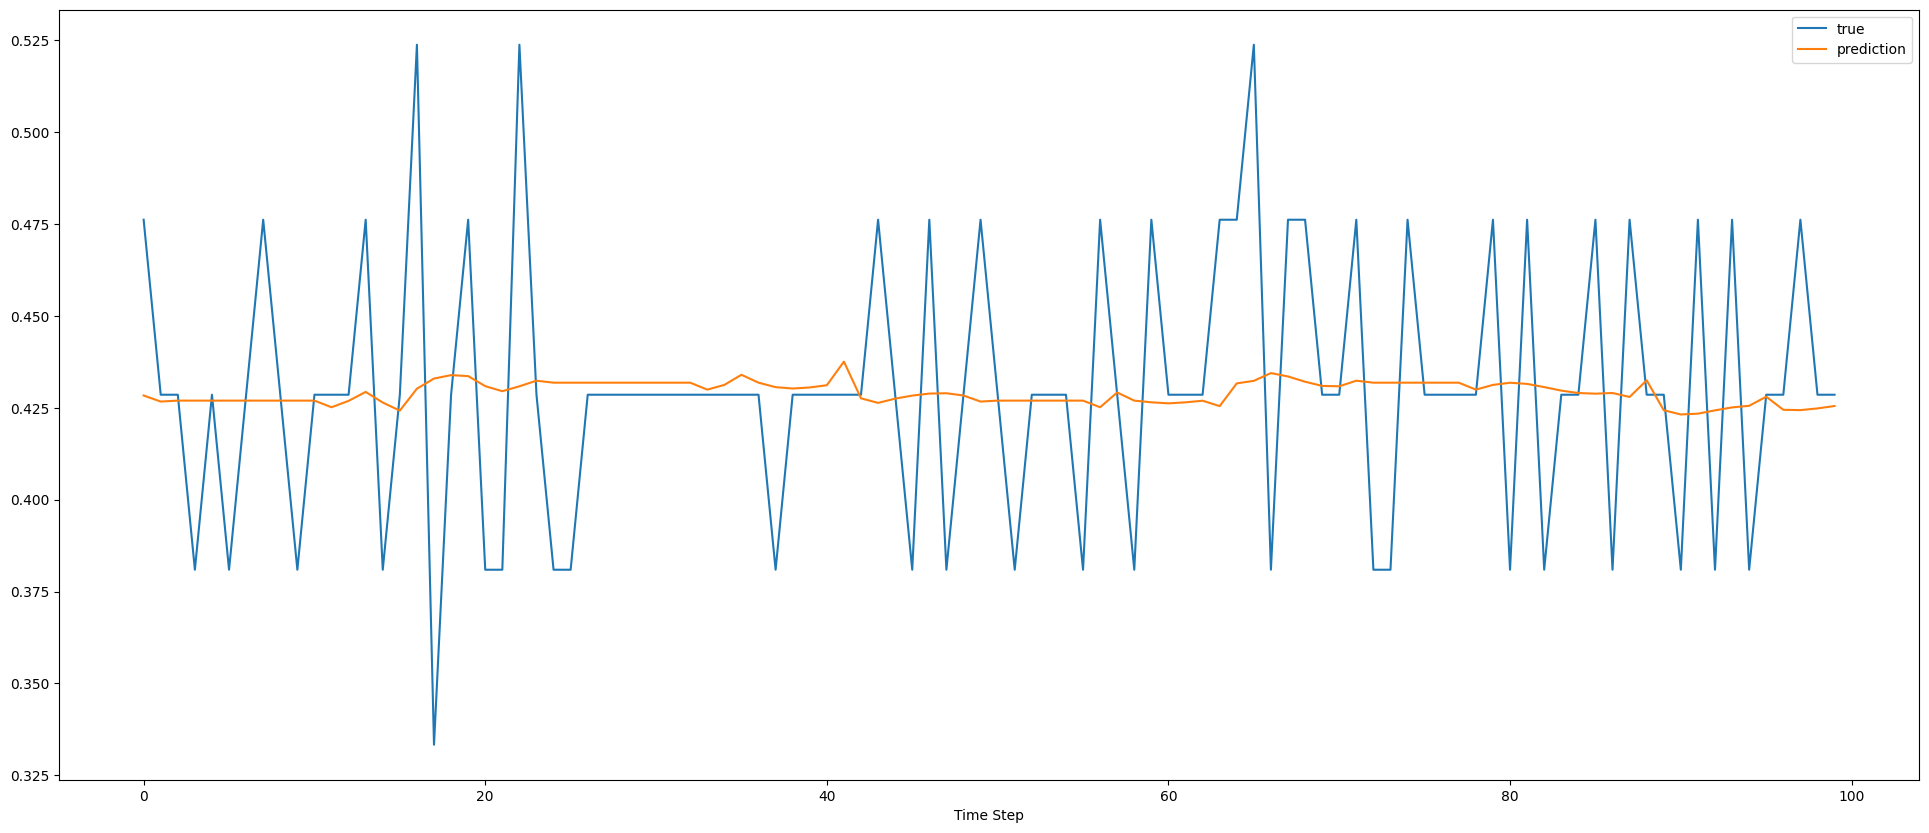

In [ ]:
plt.figure(figsize=(24,10))
plt.plot(y_test_inv.flatten()[:100], label="true")
plt.plot(y_pred_inv.flatten()[:100], label="prediction")
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [419]:
X_train, y_train

(array([[[0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.],
         ...,
         [0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.]],
 
        [[0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.],
         ...,
         [0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.]],
 
        [[0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.],
         ...,
         [0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1.]],
 
        ...,
 
        [[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]],
 
        [[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
       

In [420]:
0.20805369

0.20805369